In [1]:
import itertools
from tqdm import tqdm
from time import sleep
from math import sqrt
import multiprocessing as mp
from multiprocessing import Pool
#mp.set_start_method('spawn')

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

font = {'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 6, 5
plt.rcParams['figure.dpi'] = 90
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-whitegrid')

Defines and evaluates denominators in the RG equations. The denominators in the RG equations are
$$
d_0 = \omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{K}{2}
$$
$$
d_1 = \omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{J}{2}
$$
$$
d_2 = \omega - \frac{1}{2}\left(D - \mu\right) + \frac{J}{4} + \frac{K}{4}
$$

In [2]:
def den(w, D, U, J, K):
    d0 = w - 0.5 * D - U/2 + K/2
    d1 = w - 0.5 * D + U/2 + J/2
    d2 = w - 0.5 * D + J/4 + K/4
    return d0, d1, d2

# RG Equations

The RG equations for the symmetric spin-charge Anderson-Kondo are 

$$
\Delta U = 4|V|^2 \left[\frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{1}{2}J}  - \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{1}{2}K}\right] + \sum_{k<\Lambda_j} \frac{3}{4}\frac{K^2 - J^2}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K}
$$

$$
\Delta V = \frac{V K}{16}\left(\frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{1}{2}K} + \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K} \right) - \frac{3VJ}{4}\left( \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{1}{2}J} + \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K} \right)
$$

$$
\Delta J = - J^2\left(\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K\right)^{-1}
$$

$$
\Delta K = - K^2\left(\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K\right)^{-1}
$$

The following equation accepts the coupling values at the $j^{th}$ step of the RG, applies the RG equations on them and returns the couplings for the $(j-1)^{th}$ step. _If any coupling changes sign, it is set to 0._

In [3]:

def rg(w, D, U, V, J, K):
    dens = den(w, D, U, J, K)
    deltaU = -4 * V**2 * (1/dens[0] - 1/dens[1]) - (3* (J**2 - K**2)/8) * D / dens[2]
    deltaV = (1/16) * K * V * (1/dens[0] - 1/dens[2]) - (3/4) * J * V * (1/dens[1] + 1/dens[2])
    deltaJ = - J**2 / dens[2]
    deltaK = - K**2 / dens[2]

    #n = 2*np.pi*N*sqrt(D/Df)
    n = 1
    U = 0 if (U + n*deltaU) * U <= 0 else U + n*deltaU
    V = 0 if (V + n*deltaV) * V <= 0 else V + n*deltaV
    J = 0 if (J + n*deltaJ) * J <= 0 else J + n*deltaJ
    K = 0 if (K + n*deltaK) * K <= 0 else K + n*deltaK

    return U, V, J, K

The following function does one complete RG for a given set of bare couplings and returns arrays of the flowing couplings.

In [4]:
def complete_RG(w, D0, U0, V0, J0, K0):
    U = U0
    V = V0
    J = J0
    K = K0
    N = 100
    old_den = den(w, D0, U, J, K)[2]
    x, y1, y2, y3, y4, y5 = [], [], [], [], [], []
    flag = False
    count = N+1
    for D in np.linspace(D0, 0, N):
        count -= 1
        x.append(D)
        y1.append(U)
        y2.append(J)
        y3.append(K)
        y4.append(V)
        y5.append(count)
        new_den = den(w, D, U, J, K)[2]
        if old_den * new_den <= 0:
            flag = True
            return [x, y1, y2, y3, y4, flag, y5]
        old_den = new_den
        U, V, J, K = rg(w, D, U, V, J, K)
    return [x, y1, y2, y3, y4, flag, y5]

# 1. $V=0$

First we will look at the simplified case of $V=0$. Since the RG equation for $V$ involves $V$, it will not flow. We need to look only at $U$, $J$ and $K$. Depending on the value of $\omega$, the denominator can be either positive or negative. We look at the two cases separately.

## a. $\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K>0$ (high $\omega$):

These aren't truly URG fixed points because the denominator will not converge towards zero.

### i. $J=K$

Since $\Delta U \propto K^2 - J^2$, $U$ will be marginal here.

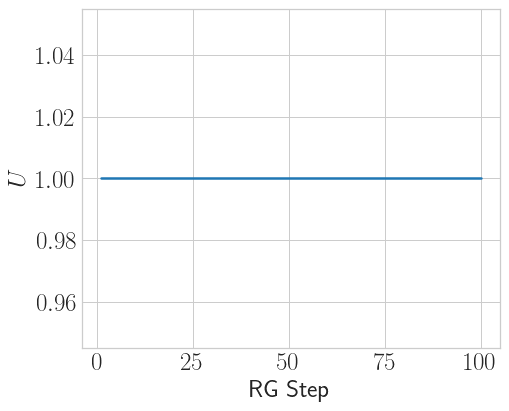

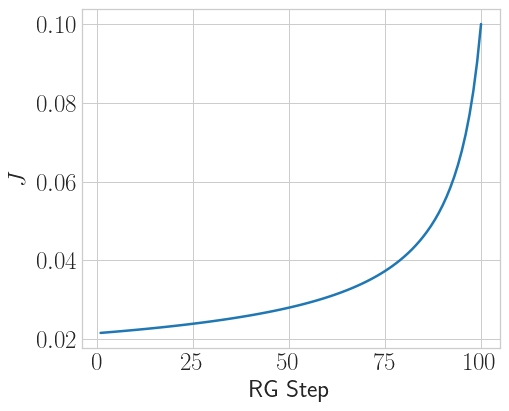

In [5]:
w = 6
D0 = 10
U0 = 1
J0 = K0 = 0.1
V0 = 0
Df = D0/2
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0)
plt.ylabel(r'$U$')
plt.xlabel(r'RG Step')
plt.plot(y5, y1)
plt.show()
plt.ylabel(r'$J$')
plt.xlabel(r'RG Step')
plt.plot(y5, y2)
plt.show()

### ii. $J > K$

Since $\Delta U \propto K^2 - J^2$, $U$ will be irrelevant here.

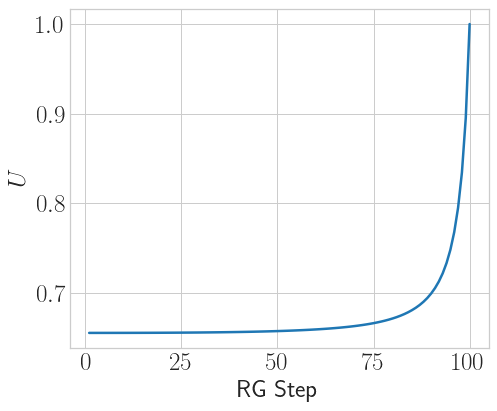

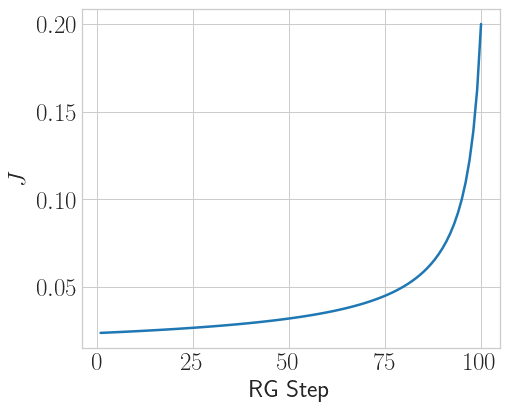

In [6]:
w = 6
D0 = 10
U0 = 1
J0 = 0.2
K0 = 0.1
V0 = 0
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0)
plt.ylabel(r'$U$')
plt.xlabel(r'RG Step')
plt.plot(y5, y1)
plt.show()
plt.ylabel(r'$J$')
plt.xlabel(r'RG Step')
plt.plot(y5, y2)
plt.show()

### iii. $J < K$

Since $\Delta U \propto K^2 - J^2$, $U$ will be relevant here.

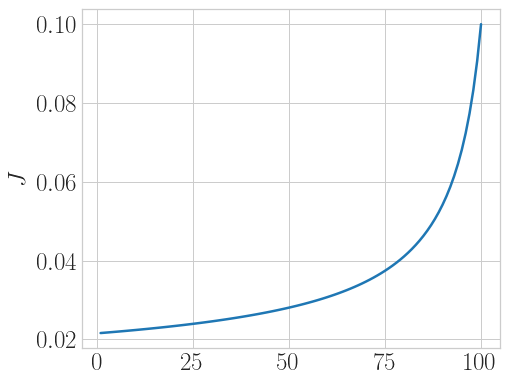

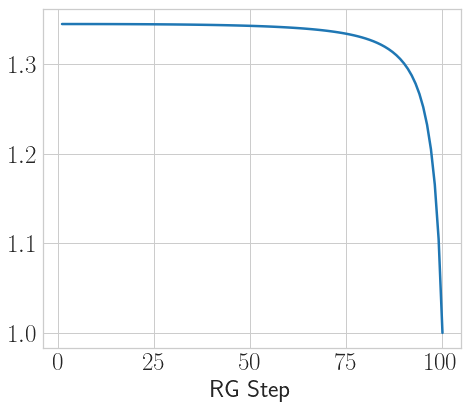

In [7]:
w = 6
D0 = 10
U0 = 1
J0 = 0.1
K0 = 0.2
V0 = 0
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0)
plt.ylabel(r'$U$')
plt.ylabel(r'$J$')
plt.plot(y5, y2)
plt.show()
plt.xlabel(r'RG Step')
plt.xlabel(r'RG Step')
plt.plot(y5, y1)
plt.show()

## b. $\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K<0$ (low $\omega$):

This is the regime where we achieve true strong-coupling fixed points in $J,K$. The signature of $K^2 - J^2$ will determine whether $U$ is relevant or irrelevant.

### i. $J>K$

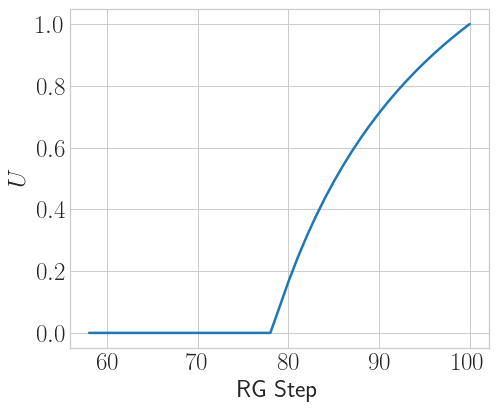

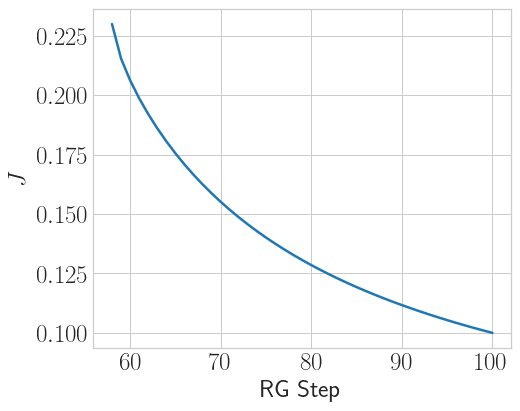

In [8]:
w = 0.01
D0 = 20
U0 = 1
J0 = 0.1
K0 = 0.2
V0 = 0
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0)
if flag == True:
    plt.ylabel(r'$U$')
    plt.plot(y5, y1)
    plt.xlabel(r'RG Step')
    plt.show()
    plt.ylabel(r'$J$')
    plt.xlabel(r'RG Step')
    plt.plot(y5, y2)
    plt.show()
else:
    print ("Not fixed point.")

### i. $J<K$

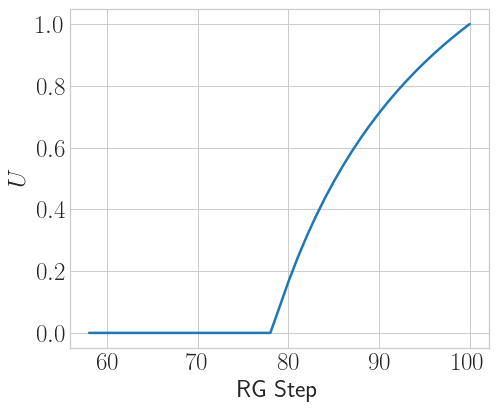

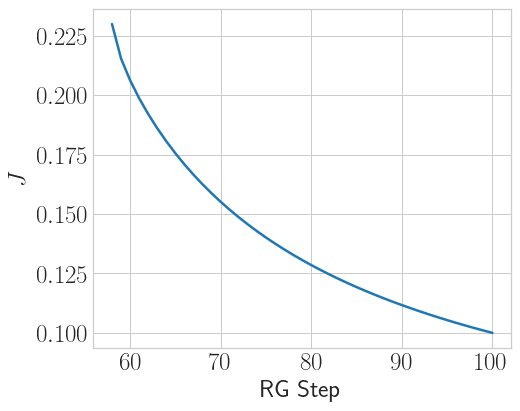

In [9]:
w = 0.01
D0 = 20
U0 = 1
J0 = 0.1
K0 = 0.2
V0 = 0
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0)
if flag == True:
    plt.ylabel(r'$U$')
    plt.xlabel(r'RG Step')
    plt.plot(y5, y1)
    plt.show()
    plt.ylabel(r'$J$')
    plt.xlabel(r'RG Step')
    plt.plot(y5, y2)
    plt.show()
else:
    print ("Not fixed point.")

To wrap up the $V=0$ case, we look at an RG-invariant:

$\frac{\Delta J}{\Delta K} = \frac{J^2}{K^2} \implies \frac{1}{J} - \frac{1}{K} = \frac{1}{J_0} - \frac{1}{K_0}$

Note that this is an invariant even when $V$ is turned on.

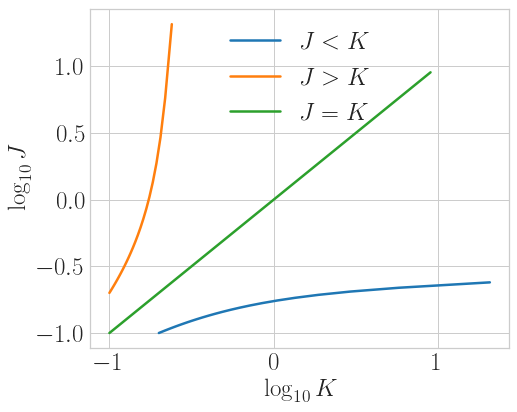

In [10]:
w = 0.1
D0 = 10
U0 = 1
J0 = 0.1
K0 = 0.2
V0 = 0
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0)
if flag == False:
    print ("It is not a fixed point.")
    exit
plt.xlabel(r"$\log_{10}K$")
plt.ylabel(r"$\log_{10}J$")
plt.plot(np.log10(y3), np.log10(y2), label=r'$J<K$')
J0 = 0.2
K0 = 0.1
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0)
if flag == False:
    print ("It is not a fixed point.")
    exit
plt.plot(np.log10(y3), np.log10(y2), label=r'$J>K$')
J0 = 0.1
K0 = 0.1
x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0)
if flag == False:
    print ("It is not a fixed point.")
    exit
plt.plot(np.log10(y3), np.log10(y2), label=r'$J=K$')
plt.legend()
plt.show()

## Phase Diagram

<img src="../figures/phases.svg" align="left" width=50%>


# 2. $V > 0$

The inclusion of $V$ will mean that there will not by any sharply defined phase of $U^*$ any more. We will still be working in the regime where $J,K$ flow to strong-coupling, and since those RG equations do not depend on $V$, their flows are unchanged. The behaviour of $U$ will get complicated however. To make 
sense, we will see how the total (over a range of $\omega$ and bare $U$) number of fixed points where $U^* > U_0$ and the total number of fixed points where $U^* < U_0$, in each of the four quadrants of the phase diagram, varies against the bare value $V_0$.

## a. Behaviour of distribution of fixed points as a function of bare $V$

We can classify the fixed points into three classes: $U*=0$, $U^* > U_0$ and $U^* < U_0$. The number of fixed points in each class for $V=0$ has already been clarified in the $V=0$ section, specially in the phase diagram. For that, we will first create some helper functions.
- count_fp(args): returns the fraction of fixed points with $U^*=0$ ($c_0$), $U^* > U_0$ ($c_1$) and $U^* < U_0$ ($c_2$), for given values of $D_0, V_0, J_0, K_0$
- get_Vc(args): returns the critical $V_0$ at which $c_0=c_1+c_2$
- plot_count(args): just plots the fraction of fixed points in each class as a function of bare values, given the data
- plot_frac(args): just plots the fraction of $U^*=0$ or $U^* \neq 0$ fixed points a particular $V_0$, as a function of $D$

In [11]:
def count_fp(D0, V0, J0, K0, sign, delta=0.01):
    w_range = np.arange(-D0/2, D0/2, delta)
    U_range = np.arange(sign*delta, sign*(5 + delta), sign*delta)
    data = itertools.product(w_range, [D0], U_range, [V0], [J0], [K0])
    count = np.zeros(3)
    for outp in Pool(processes=50).starmap(complete_RG, data):
        U0 = outp[1][0]
        U_fp = outp[1][-1]
        if outp[-2] == False and U_fp != 0:
            continue
        if U_fp == 0:
            count[0] += 1
        elif U_fp > U0:
            count[1] += 1
        elif U_fp < U0:
            count[2] += 1
    return count

In [12]:
def get_Vc(V0_range, c0, c1):
    diff = (c1-c0)[0]
    for i in range(1,len(c1-c0)):
        if diff * (c1-c0)[i] <=0 :
            return V0_range[i]
    return -1

In [13]:
def plot_count(V0_range, count, title):
    y = [np.array(c)/sum(count) for c in count]
    plt.plot(V0_range, y[0], color='r', label=r"$U^*=0$" )
    plt.plot(V0_range, y[1], color='b', label=r"$U^* > U_0$")
    plt.plot(V0_range, y[2], color='g', label=r"$U^* < U_0$")
    plt.legend()
    plt.title(title)
    plt.xlabel(r"$V_0$")
    plt.ylabel(r"fraction of fixed points")
    plt.show()

In [14]:
def plot_frac(D0_range, V0, frac, title):
    plt.plot(D0_range, frac[0])
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"ratio of $U^*=0$ and $U^*\neq 0$")
    plt.title(title+" $V_0 = {}$".format(V0[0]))
    plt.show()
    plt.plot(D0_range, frac[1])
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"ratio of $U^*=0$ and $U^*\neq 0$")
    plt.title(title+" $V_0 = {}$".format(V0[1]))
    plt.show()

We will first check how the $c_i$ vary as functions of $V$, in each quadrant.

In [17]:
def sweep_V(J0, K0, sign, title, V0_range, D0_range=range(5, 21, 3)):
    for D0 in D0_range:
        c0, c1, c2 = [], [], []
        for V0 in tqdm(V0_range):
            count = count_fp(D0, V0, J0, K0, sign, delta=0.1)
            c0.append(count[0])
            c1.append(count[1])
            c2.append(count[2])
        c0, c1, c2 = np.array(c0), np.array(c1), np.array(c2)
        plot_count(V0_range, [c0, c1, c2], title+r", $D={}$".format(D0))

## First Quadrant: $U>0, J>K$

100%|██████████| 4/4 [07:30<00:00, 112.72s/it]


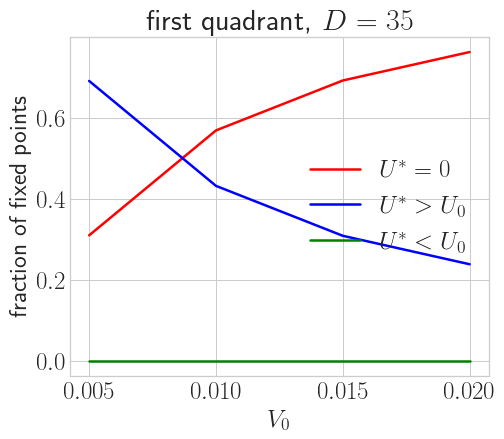

100%|██████████| 4/4 [09:04<00:00, 136.02s/it]


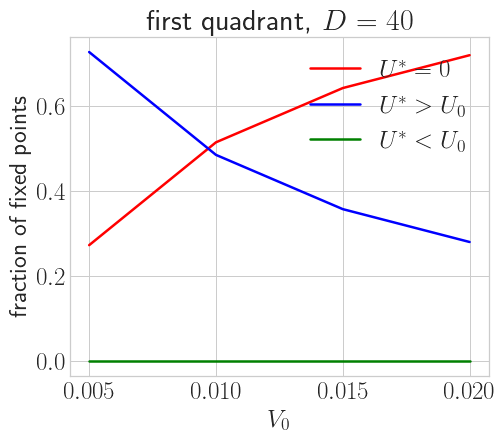

100%|██████████| 4/4 [10:36<00:00, 159.13s/it]


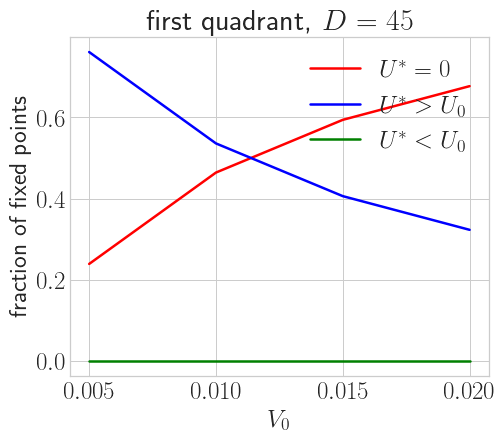

100%|██████████| 4/4 [12:01<00:00, 180.48s/it]


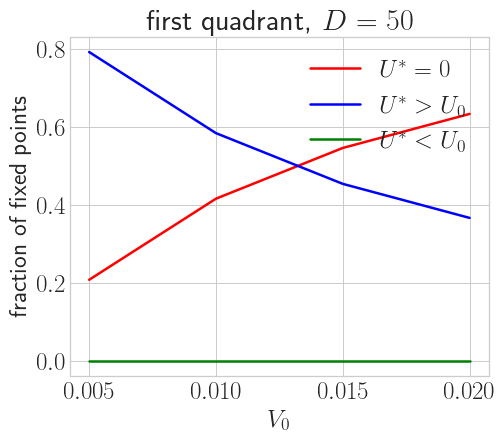

100%|██████████| 4/4 [13:22<00:00, 200.74s/it]


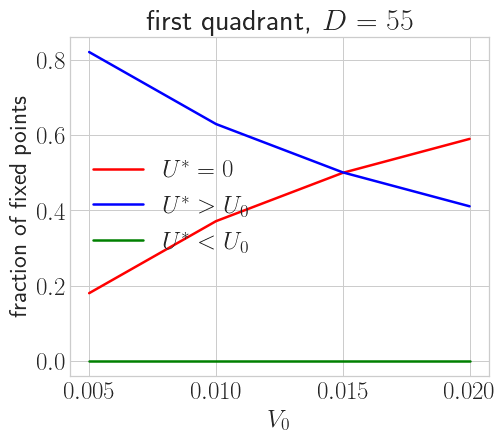

100%|██████████| 4/4 [14:42<00:00, 220.73s/it]


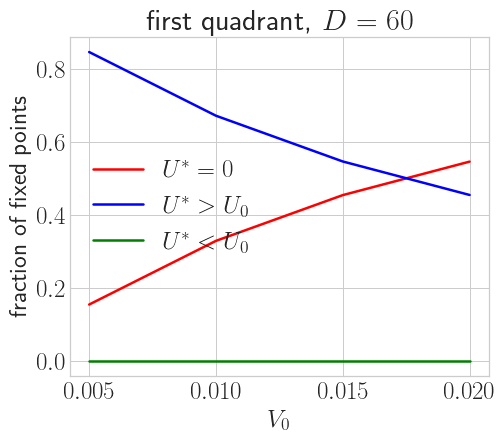

In [16]:
sweep_V(0.2, 0.1, 1, r"first quadrant", np.arange(0.0001,0.01+0.0001,0.0001), np.arange(1,16,2))
sweep_V(0.2, 0.1, 1, r"first quadrant", np.arange(0.005,0.02+0.0001,0.0001), np.arange(35,100,5))

As $D$ increases, dominant fixed point switches from $U^*>0$ to $U^*=0$. Plot the variation of critical $V$ and that of $\frac{c_0}{c_1}$ at $V_0=0.02$, both against $D$.

## Second Quadrant: $U>0, J<K$

In [ ]:
sweep_V(0.1, 0.2, 1, r"second quadrant", np.arange(0.1,5,0.5), np.arange(10,50,5))

With increase in $D$, the hump keeps moving forward, so the dominant behaviour is unchanged (still $U^*=0$). The hump disappears at a sufficiently large $D$. Next, plot the fraction $\frac{c0}{c1}$ at $V_0=2$, versus $D$.

## Third Quadrant: $U<0, J<K$

In [ ]:
sweep_V(0.1, 0.2, -1, r"third quadrant", np.arange(0.1,5,0.5))

Its clear that $U^*< U_0$ is still the dominant fixed point here.

## Fourth Quadrant: $U<0, J>K$

In [ ]:
sweep_V(0.2, 0.1, -1, r"fourth quadrant", np.arange(0.1,5,0.5), np.arange(3,16,3))

In the fourth quadrant, the $V$ causes significant changes only at very small $D$. We can plot $\frac{c_0}{c_1}$ at $V_0 = 0.5$ versus $D$. 

## $\frac{c_0}{c_1}$ at $V_0=0.02$ and $V_c$, both vs $D$, for the $1^\text{st}$ quadrant

In [17]:
J0 = 0.2
K0 = 0.1
sign = 1
Vc = []
frac = []
V0_start = 0.0086
D0_range=range(5, 26, 2)
for D0 in D0_range:
    Vi = [0.02, 1]
    diff = 0
    frac.append([])
    for V0 in tqdm(np.arange(V0_start, 0, -0.00005)):
        count = count_fp(D0, V0, J0, K0, sign, delta=0.1)
        if V0 in Vi:
            frac[-1].append(count[0]/sum(count))
            Vi.remove(V0)
        if diff == 0:
            diff = np.sign(count[0] - count[1])
        elif diff * np.sign(count[0] - count[1]) <= 0:
            V0_start = V0 + 0.00005
            Vc.append([D0, V0])
            break
    for V0 in Vi:
        count = count_fp(D0, V0, J0, K0, sign, delta=0.1)
        frac[-1].append(count[0]/sum(count))

Vc = np.array(Vc)
frac = np.array(frac)
plt.plot(Vc[:,0], Vc[:,1], marker="o")
plt.title(r"$V_c$")
plt.show()
plt.plot(D0_range, frac[:,0], marker="o")
plt.title(r"$\frac{c_0}{sum(c)}$ at $V=0.02$")
plt.show()
plt.plot(D0_range, frac[:,1], marker="o", label=r"$V=1$")
plt.title(r"$\frac{c_0}{sum(c)}$ at $V=1$")
plt.show()



  3%|▎         | 4/153 [00:04<02:47,  1.12s/it]


KeyboardInterrupt: 

In [21]:
V0_start = 0.00640
Vc = []
frac = []
D0_range=range(26, 100, 5)
for D0 in D0_range:
    Vi = [0.015, 1]
    diff = 0
    frac.append([])
    for V0 in tqdm(np.arange(V0_start, 1, 0.00005)):
        count = count_fp(D0, V0, J0, K0, sign, delta=0.1)
        if V0 in Vi:
            frac[-1].append(count[0]/count[1])
            Vi.remove(V0)
        if diff == 0:
            diff = np.sign(count[0] - count[1])
        elif diff * np.sign(count[0] - count[1]) <= 0:
            V0_start = V0 - 0.00005
            Vc.append([D0, V0])
            break
    for V0 in Vi:
        count = count_fp(D0, V0, J0, K0, sign, delta=0.1)
        frac[-1].append(count[0]/count[1])

Vc = np.array(Vc)
frac = np.array(frac)
print (Vc)
print (frac)
plt.plot(Vc[:,0], Vc[:,1], marker="o")
plt.show()
plt.plot(D0_range, frac[:,0], marker="o", label=r"$V=0.02$")
plt.plot(D0_range, frac[:,1], marker="o", label=r"$V=1$")
plt.legend()
plt.show()

  0%|          | 1/19631 [00:09<54:24:14,  9.98s/it]Process ForkPoolWorker-70073:
Process ForkPoolWorker-70078:
Process ForkPoolWorker-70079:
Process ForkPoolWorker-70071:
Process ForkPoolWorker-70069:
Process ForkPoolWorker-70080:
Process ForkPoolWorker-70065:
Process ForkPoolWorker-70076:
Process ForkPoolWorker-70050:
Process ForkPoolWorker-70051:
Process ForkPoolWorker-70053:
Process ForkPoolWorker-70057:
Process ForkPoolWorker-70044:
Process ForkPoolWorker-70068:
Process ForkPoolWorker-70047:



KeyboardInterrupt: 

## Comparison of $J^*$ and $V^*$

In [ ]:
def plot_JvsV(sign1, sign2, title):
    D0_range = range(10,51,10)
    V0_range = np.arange(0.002,1+0.002,0.002)
    for D0 in D0_range:
        Jfp = []
        Vfp = []
        V = []
        for V0 in V0_range:
            if sign1 > 0:
                J0 = V0
                K0 = J0 - 0.001
            else:
                K0 = V0
                J0 = K0 - 0.001
            U0 = sign2
            for w in np.arange(-D0/2, D0/2, 0.1):
                x, y1, y2, y3, y4, flag, y5 = complete_RG(w, D0, U0, V0, J0, K0)
                if flag == True:
                    V.append(V0)
                    Jfp.append(y2[-1])
                    Vfp.append(y4[-1])
                    break
        V = np.array(V)
        diff = np.array(Vfp)-np.array(Jfp)
        pos = np.where(diff > 0)
        neg = np.where(diff < 0)
        y1 = diff[pos]
        x1 = V[pos]
        y2 = diff[neg]
        x2 = V[neg]
        plt.scatter(x1, np.log10(np.absolute(y1)), color='r', marker='.', label=r"$V^* > J^*$")
        plt.scatter(x2, np.log10(np.absolute(y2)), color='b', marker='o', label=r"$V^* < J^*$")
        plt.title(r"$D={}$".format(D0))
        plt.legend()
        plt.xlabel(r"$V_0$")
        plt.ylabel(r"$\log_{10}|V^* - J^*|$")
        plt.show()

In [ ]:
plot_JvsV(1, 1, r'first quadrant')

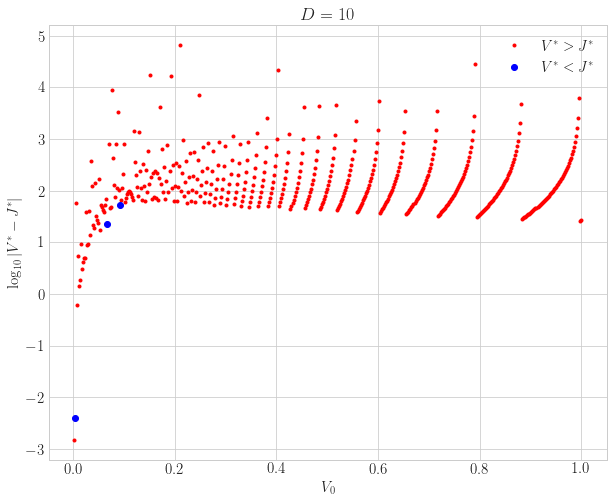

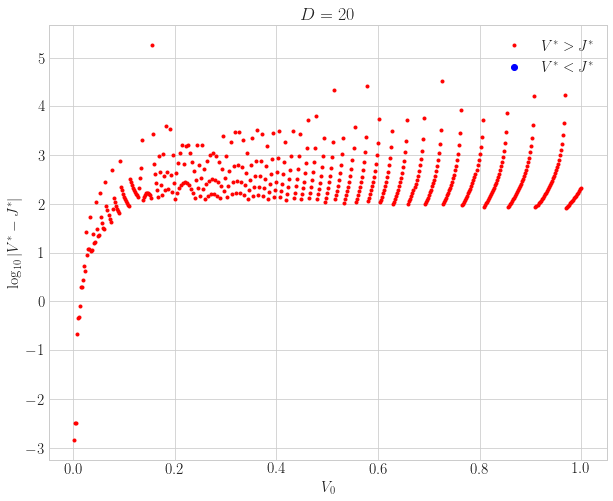

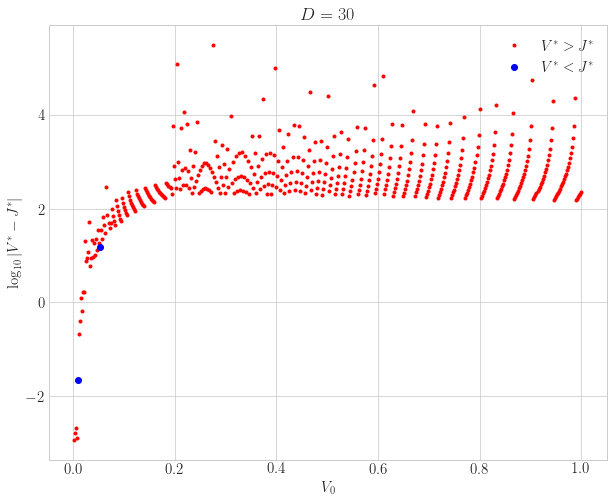

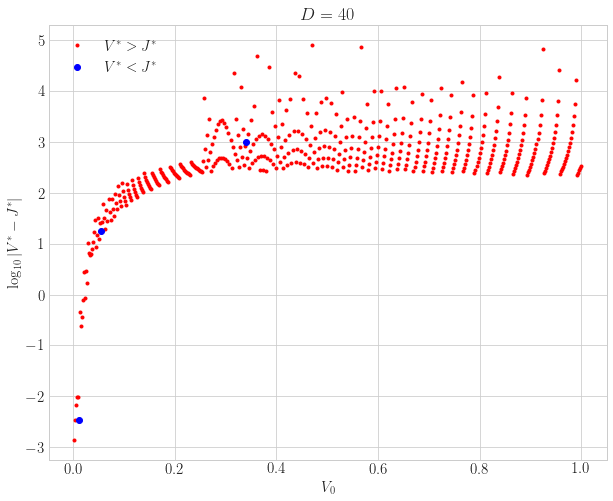

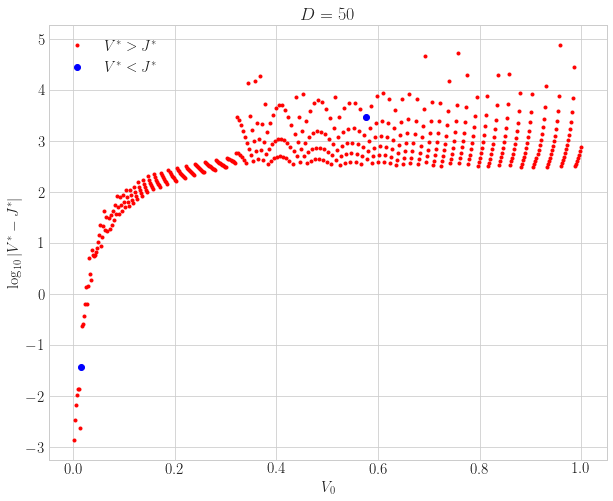

In [22]:
plot_JvsV(-1, 1, r'second quadrant')

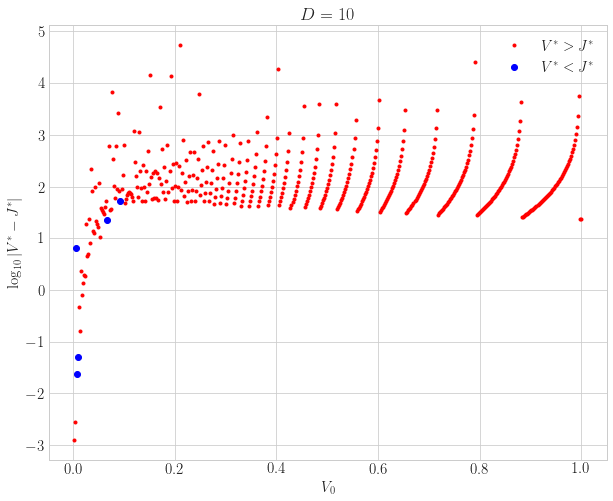

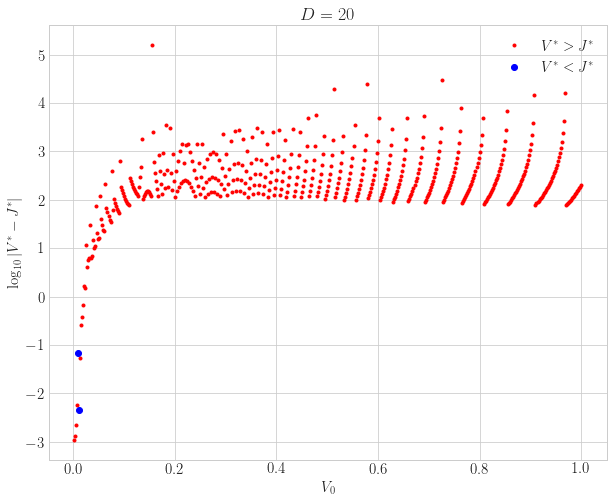

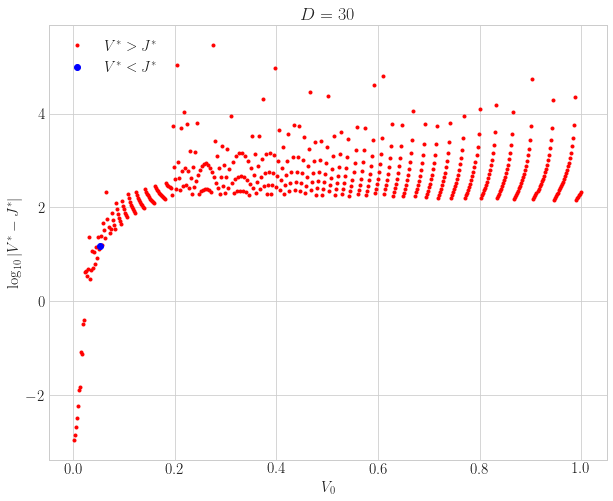

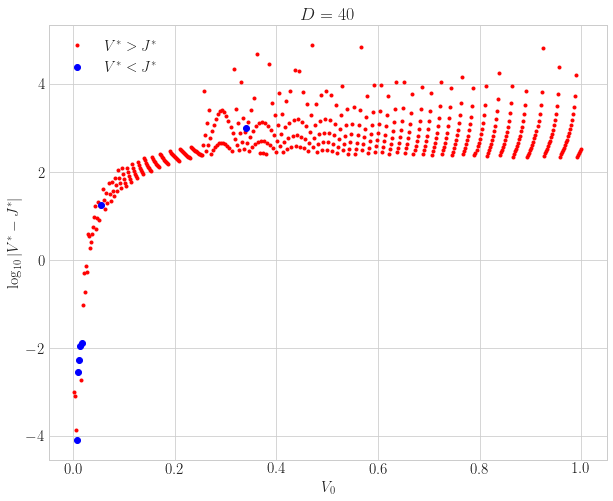

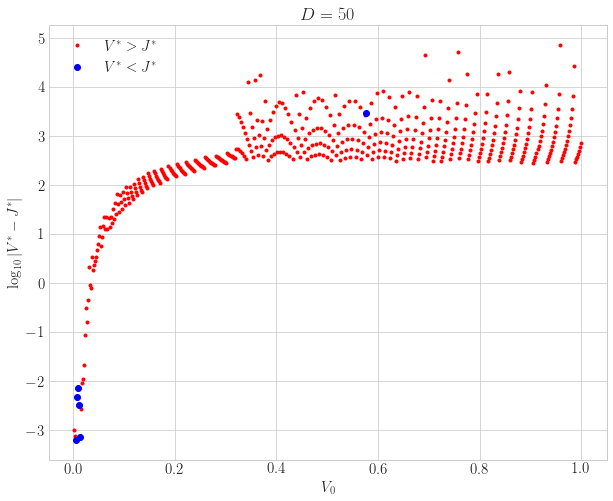

In [23]:
plot_JvsV(-1, -1, r'third quadrant')

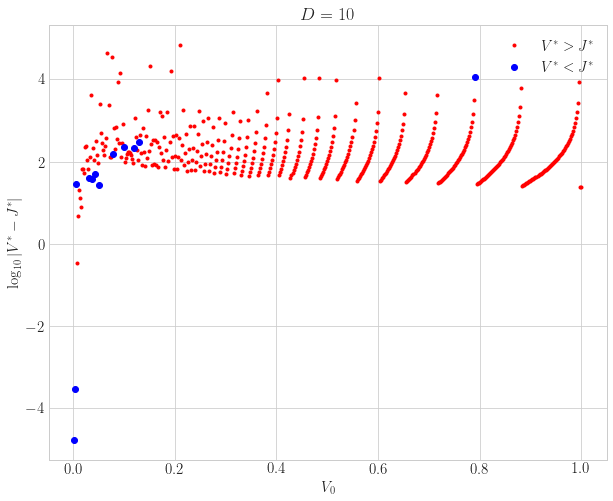

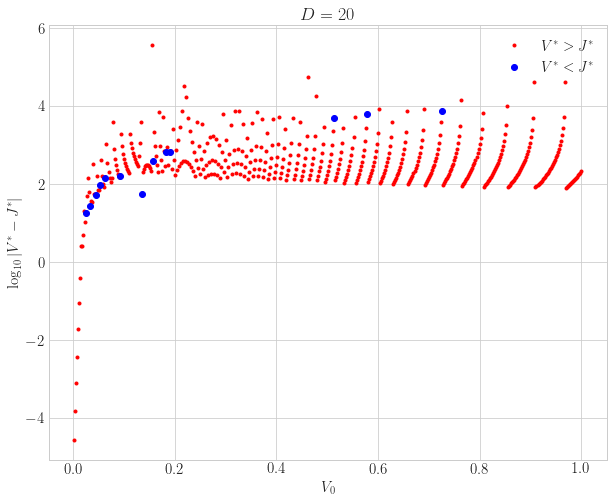

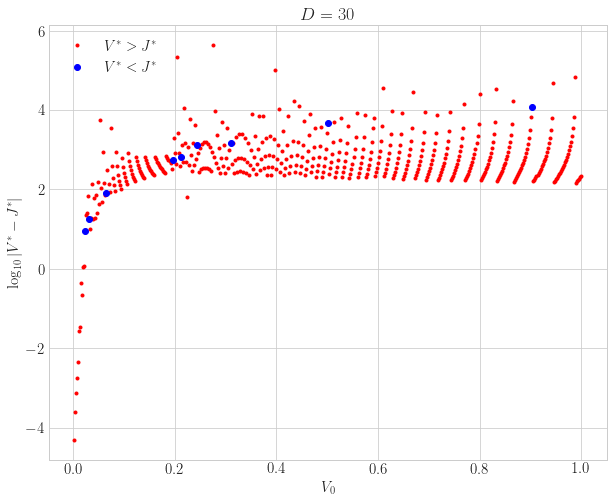

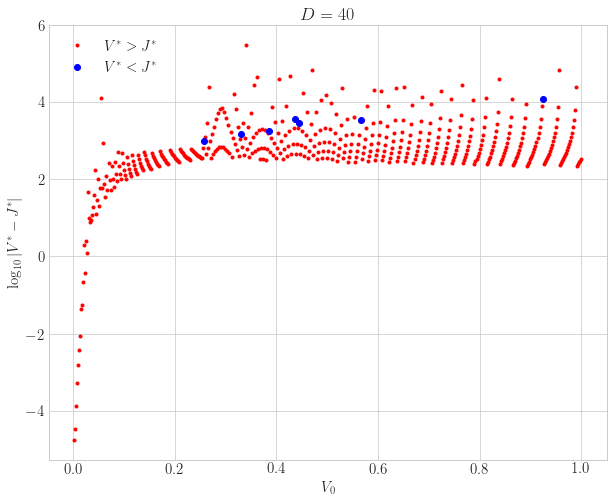

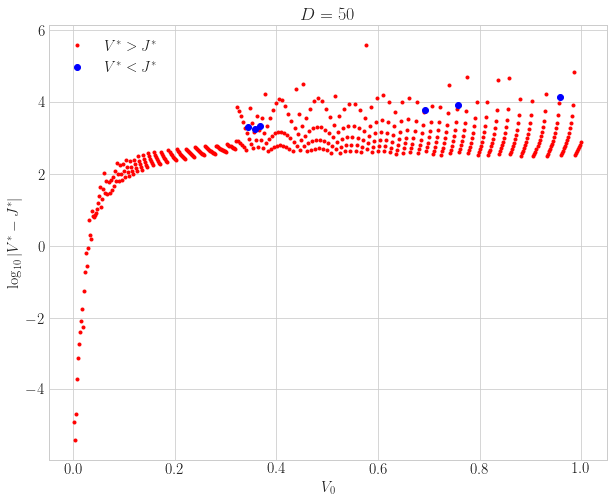

In [24]:
plot_JvsV(1, -1, r'fourth quadrant')

## Behaviour of $V$

In [16]:
def count_Vfp(D0, V0, J0, K0, sign=1, delta=0.05):
    w_range = np.arange(-D0/2, D0/2, delta)
    U_range = np.arange(sign*delta, sign*(10 + delta), sign*delta)
    data = itertools.product(w_range, [D0], U_range, [V0], [J0], [K0])
    count = np.zeros(3)
    for outp in Pool(processes=50).starmap(complete_RG, data):
        V_fp = outp[4][-1]
        if V_fp ==0:
            count[0] += 1
        elif V_fp > V0:
            count[1] += 1
        elif V_fp < V0:
            count[2] += 1
    return count

def plot_Vcount(V0_range, count, title):
    plt.plot(V0_range, count[0], marker=".", color='r', label=r"$V^*=0$" )
    plt.plot(V0_range, count[1], marker=".", color='b', label=r"$V^* > V_0$")
    plt.plot(V0_range, count[2], marker=".", color='g', label=r"$V^* < V_0$")
    plt.legend()
    plt.title(title)
    plt.xlabel(r"$V_0$")
    plt.ylabel(r"fraction of fixed points")
    plt.show()

def plot_all(J0, K0, sign, title, V0_range=np.arange(0.001,0.101,0.001), D0_range = range(10, 20, 3)):
    for D0 in D0_range:
        c0, c1, c2 = [], [], []
        for V0 in V0_range:
            print (V0)
            count = count_Vfp(D0, V0, J0, K0, sign)
            c0.append(count[0]/sum(count))
            c1.append(count[1]/sum(count))
            c2.append(count[2]/sum(count))
        plot_Vcount(V0_range, [c0, c1, c2], title+r", $D={}$".format(D0))

0.001
0.0012000000000000001
0.0014000000000000002
0.0016000000000000003
0.0018000000000000004
0.0020000000000000005
0.0022000000000000006
0.0024000000000000007
0.0026000000000000007
0.002800000000000001
0.003000000000000001
0.003200000000000001
0.003400000000000001
0.003600000000000001
0.0038000000000000013
0.004000000000000002
0.0042000000000000015
0.004400000000000001
0.004600000000000002
0.004800000000000002
0.005000000000000002
0.005200000000000002
0.005400000000000002
0.005600000000000002
0.005800000000000002
0.006000000000000003
0.006200000000000002
0.006400000000000002
0.0066000000000000026
0.006800000000000003
0.007000000000000003
0.007200000000000002
0.007400000000000003
0.0076000000000000035
0.007800000000000003
0.008000000000000004
0.008200000000000002
0.008400000000000005
0.008600000000000003
0.008800000000000002
0.009000000000000005
0.009200000000000003
0.009400000000000006
0.009600000000000004
0.009800000000000003
0.010000000000000005
0.010200000000000004
0.01040000000000

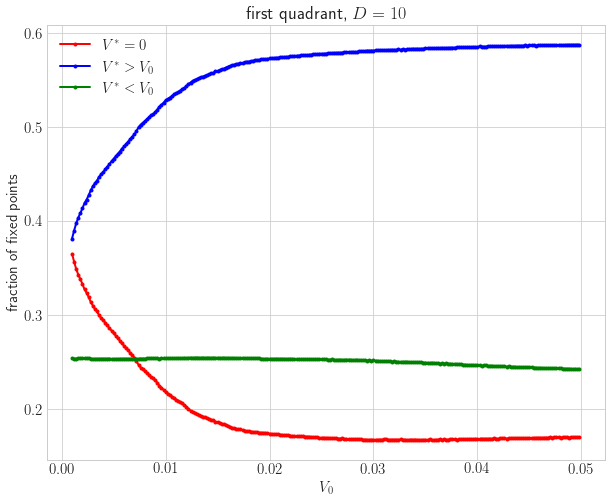

0.001
0.0012000000000000001
0.0014000000000000002
0.0016000000000000003
0.0018000000000000004
0.0020000000000000005
0.0022000000000000006
0.0024000000000000007
0.0026000000000000007
0.002800000000000001
0.003000000000000001
0.003200000000000001
0.003400000000000001
0.003600000000000001
0.0038000000000000013
0.004000000000000002
0.0042000000000000015
0.004400000000000001
0.004600000000000002
0.004800000000000002
0.005000000000000002
0.005200000000000002
0.005400000000000002
0.005600000000000002
0.005800000000000002
0.006000000000000003
0.006200000000000002
0.006400000000000002
0.0066000000000000026
0.006800000000000003
0.007000000000000003
0.007200000000000002
0.007400000000000003
0.0076000000000000035
0.007800000000000003
0.008000000000000004
0.008200000000000002
0.008400000000000005
0.008600000000000003
0.008800000000000002
0.009000000000000005
0.009200000000000003
0.009400000000000006
0.009600000000000004
0.009800000000000003
0.010000000000000005
0.010200000000000004
0.01040000000000

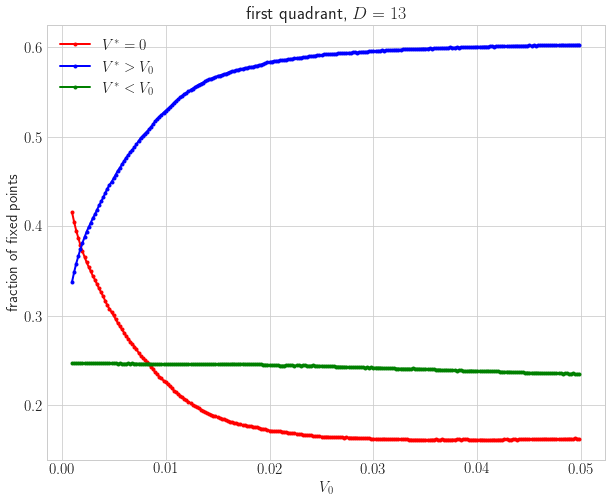

0.001
0.0012000000000000001
0.0014000000000000002
0.0016000000000000003
0.0018000000000000004
0.0020000000000000005
0.0022000000000000006
0.0024000000000000007
0.0026000000000000007
0.002800000000000001
0.003000000000000001
0.003200000000000001
0.003400000000000001
0.003600000000000001
0.0038000000000000013
0.004000000000000002
0.0042000000000000015
0.004400000000000001
0.004600000000000002
0.004800000000000002
0.005000000000000002
0.005200000000000002
0.005400000000000002
0.005600000000000002
0.005800000000000002
0.006000000000000003
0.006200000000000002
0.006400000000000002
0.0066000000000000026
0.006800000000000003
0.007000000000000003
0.007200000000000002
0.007400000000000003
0.0076000000000000035
0.007800000000000003
0.008000000000000004
0.008200000000000002
0.008400000000000005
0.008600000000000003
0.008800000000000002
0.009000000000000005
0.009200000000000003
0.009400000000000006
0.009600000000000004
0.009800000000000003
0.010000000000000005
0.010200000000000004
0.01040000000000

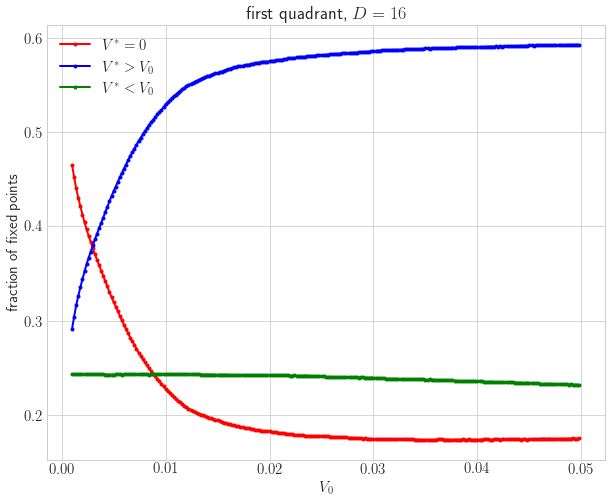

0.001
0.0012000000000000001
0.0014000000000000002
0.0016000000000000003
0.0018000000000000004
0.0020000000000000005
0.0022000000000000006
0.0024000000000000007
0.0026000000000000007
0.002800000000000001
0.003000000000000001
0.003200000000000001
0.003400000000000001
0.003600000000000001
0.0038000000000000013
0.004000000000000002
0.0042000000000000015
0.004400000000000001
0.004600000000000002
0.004800000000000002
0.005000000000000002
0.005200000000000002
0.005400000000000002
0.005600000000000002
0.005800000000000002
0.006000000000000003
0.006200000000000002
0.006400000000000002
0.0066000000000000026
0.006800000000000003
0.007000000000000003
0.007200000000000002
0.007400000000000003
0.0076000000000000035
0.007800000000000003
0.008000000000000004
0.008200000000000002
0.008400000000000005
0.008600000000000003
0.008800000000000002
0.009000000000000005
0.009200000000000003
0.009400000000000006
0.009600000000000004
0.009800000000000003
0.010000000000000005
0.010200000000000004
0.01040000000000

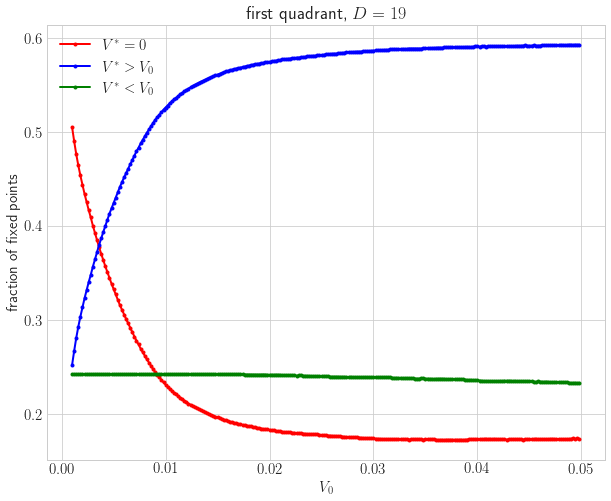

In [17]:
V0_range = np.arange(0.001,0.05,0.0002)
plot_all(0.2, 0.1, 1, r"first quadrant", V0_range=V0_range)

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011
0.012
0.013000000000000001
0.014000000000000002
0.015
0.016
0.017
0.018000000000000002
0.019000000000000003
0.02
0.021
0.022000000000000002
0.023
0.024
0.025
0.026000000000000002
0.027000000000000003
0.028
0.029
0.030000000000000002
0.031
0.032
0.033
0.034
0.035
0.036000000000000004
0.037000000000000005
0.038
0.039
0.04
0.041
0.042
0.043000000000000003
0.044000000000000004
0.045
0.046
0.047
0.048
0.049
0.05
0.051000000000000004
0.052000000000000005
0.053000000000000005
0.054
0.055
0.056
0.057
0.058
0.059000000000000004
0.060000000000000005
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.07100000000000001
0.07200000000000001
0.07300000000000001
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.08600000000000001
0.08700000000000001
0.08800000000000001
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1


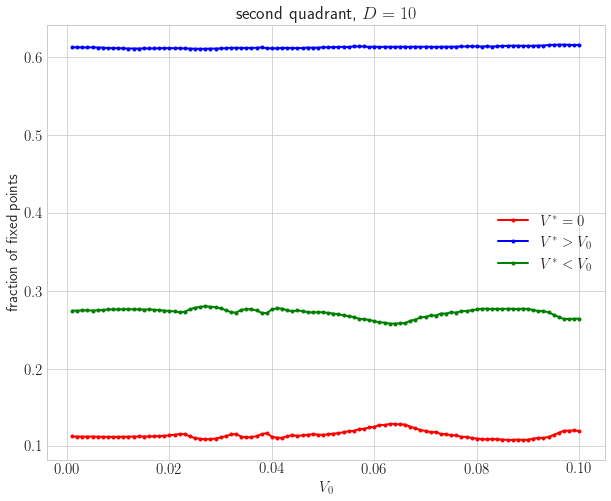

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011
0.012
0.013000000000000001
0.014000000000000002
0.015
0.016
0.017
0.018000000000000002
0.019000000000000003
0.02
0.021
0.022000000000000002
0.023
0.024
0.025
0.026000000000000002
0.027000000000000003
0.028
0.029
0.030000000000000002
0.031
0.032
0.033
0.034
0.035
0.036000000000000004
0.037000000000000005
0.038
0.039
0.04
0.041
0.042
0.043000000000000003
0.044000000000000004
0.045
0.046
0.047
0.048
0.049
0.05
0.051000000000000004
0.052000000000000005
0.053000000000000005
0.054
0.055
0.056
0.057
0.058
0.059000000000000004
0.060000000000000005
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.07100000000000001
0.07200000000000001
0.07300000000000001
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.08600000000000001
0.08700000000000001
0.08800000000000001
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1


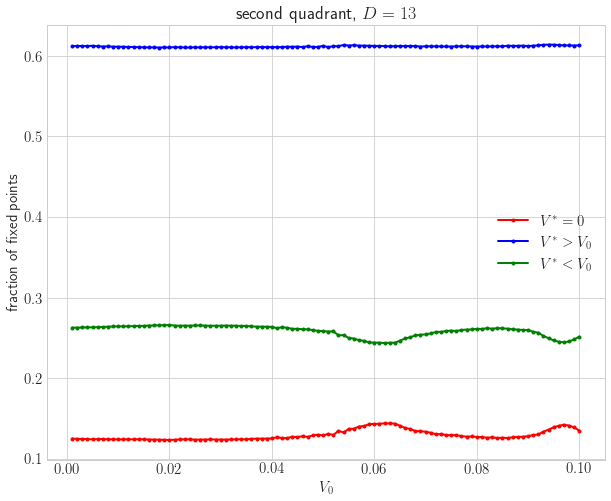

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011
0.012
0.013000000000000001
0.014000000000000002
0.015
0.016
0.017
0.018000000000000002
0.019000000000000003
0.02
0.021
0.022000000000000002
0.023
0.024
0.025
0.026000000000000002
0.027000000000000003
0.028
0.029
0.030000000000000002
0.031
0.032
0.033
0.034
0.035
0.036000000000000004
0.037000000000000005
0.038
0.039
0.04
0.041
0.042
0.043000000000000003
0.044000000000000004
0.045
0.046
0.047
0.048
0.049
0.05
0.051000000000000004
0.052000000000000005
0.053000000000000005
0.054
0.055
0.056
0.057
0.058
0.059000000000000004
0.060000000000000005
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.07100000000000001
0.07200000000000001
0.07300000000000001
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.08600000000000001
0.08700000000000001
0.08800000000000001
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1


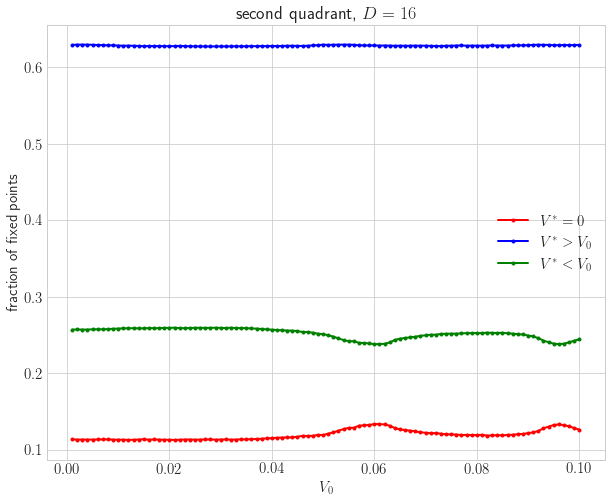

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011
0.012
0.013000000000000001
0.014000000000000002
0.015
0.016
0.017
0.018000000000000002
0.019000000000000003
0.02
0.021
0.022000000000000002
0.023
0.024
0.025
0.026000000000000002
0.027000000000000003
0.028
0.029
0.030000000000000002
0.031
0.032
0.033
0.034
0.035
0.036000000000000004
0.037000000000000005
0.038
0.039
0.04
0.041
0.042
0.043000000000000003
0.044000000000000004
0.045
0.046
0.047
0.048
0.049
0.05
0.051000000000000004
0.052000000000000005
0.053000000000000005
0.054
0.055
0.056
0.057
0.058
0.059000000000000004
0.060000000000000005
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.07100000000000001
0.07200000000000001
0.07300000000000001
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.08600000000000001
0.08700000000000001
0.08800000000000001
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1


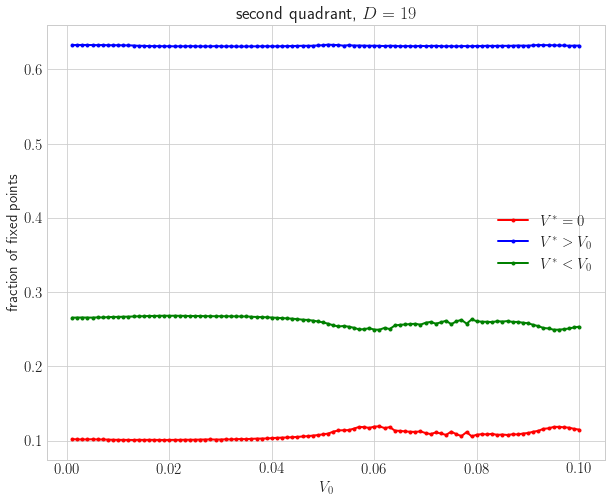

In [18]:
plot_all(0.1, 0.2, 1, r"second quadrant")

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05


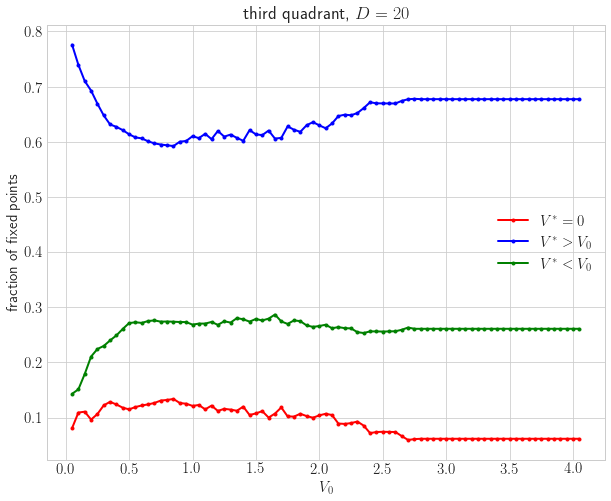

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05


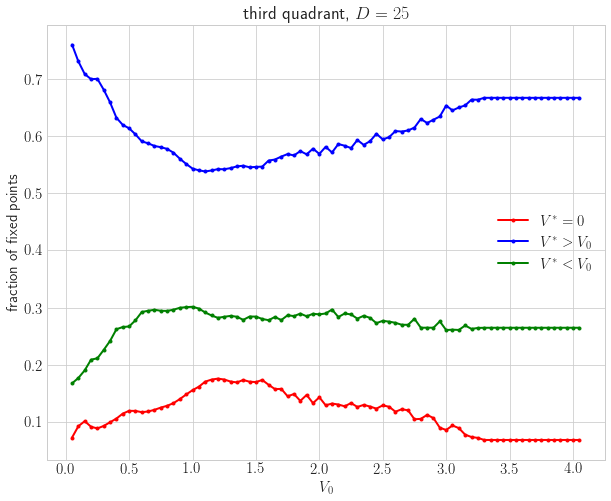

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05


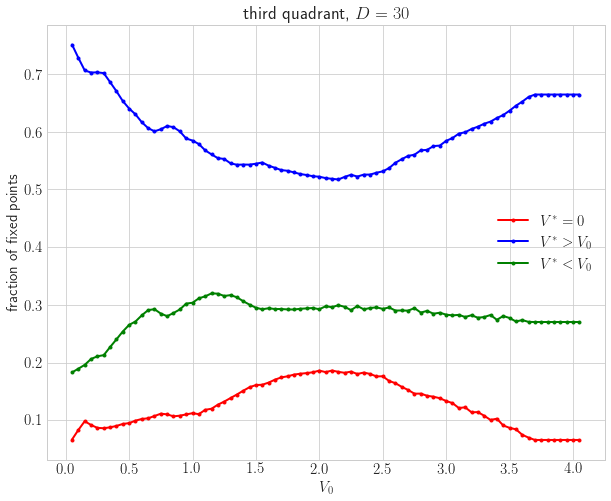

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05


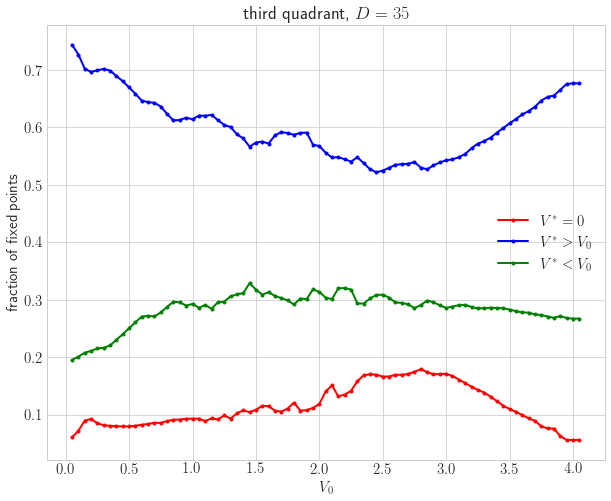

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05


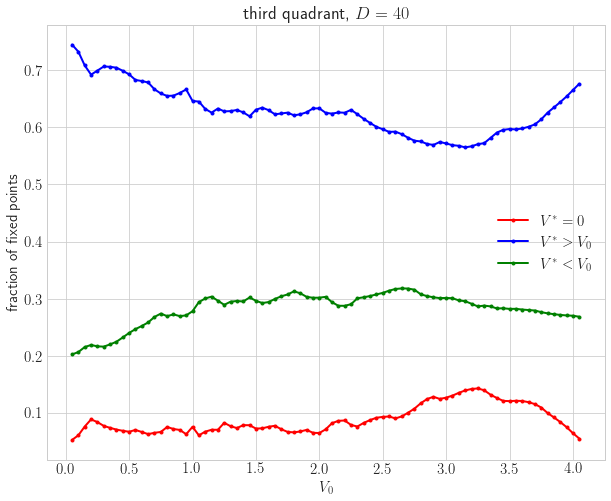

In [19]:
plot_all(0.1, 0.2, -1, r"third quadrant", V0_range=np.arange(0.05,4.1,0.05), D0_range=np.arange(20, 41, 5))

In [ ]:
plot_all(0.2, 0.1, -1, r"fourth quadrant", V0_range=np.arange(0.01,1,0.01))

## b. Change in the fraction of irrelevant fixed points under increase in $D$

Next we will see how the ratio of number of fixed points in each class varies as we increase the bandwidth, for a particular $V \sim 10$ in the stable region.

In [ ]:
def plot_frac(J0, K0, sign, title):
    D0_range = np.arange(10,91,20)
    frac = [].05
    for D0 in D0_range:
        print (D0)
        V0 = 10
        count = (count_fp(D0, V0, J0, K0, sign))
        frac.append(count[0]/sum(count))
    plt.plot(D0_range, frac, marker=".")
    plt.title(title)
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"log of ratio of irr. to rel.")
    plt.show()


#plot_frac(0.04, 0.03, 1, r"first quadrant")
#plot_frac(0.03, 0.04, 1, r"second quadrant")
#plot_frac(0.03, 0.04, -1, r"third quadrant")
#plot_frac(0.04, 0.03, -1, r"fourth quadrant")

## c. Change in the critical $V$ under increase in $D$

For the first and third quadrants, there is a critical value of $V$ at which the number of relevant and irrelevant fixed points become equal. We will now see how this value depends on the bandwidth $D$.

In [ ]:

def Vc_vs_D(J0, K0, sign, title):
    D0_range = range(10,91,20)
    Vc = [get_Vc(D0, J0, K0, sign, title) for D0 in D0_range]
    plt.plot(D0_range, Vc, marker=".")
    plt.title(title)
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"$V_c$")
    plt.show()


#Vc_vs_D(0.4, 0.3, 1, r"first quadrant")
#Vc_vs_D(0.3, 0.4, -1, r"third quadrant")